<a href="https://colab.research.google.com/github/wisnupMD/Thesis-FILM-Model-Footage/blob/main/Thesis_Frame_Interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tinggal Ganti urutan frame sesuai catatan di tablet**

**Preparation**
Untuk instalasi requirement library, silakan dikumpulkan disini

In [ ]:
!pip install opencv-python #block code 5
!pip install mediapy #block code 11
!apt-get install -y ffmpeg #block code 11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.0 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


**Import Video**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Runtime selalu disconnect setelah running yang ini
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/drive/MyDrive/Prep_Thesis/realfootage/ExpFootage720p.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

**Extract Frame dari Video**

In [ ]:
import cv2
import os
video_path = '/content/drive/MyDrive/Prep_Thesis/realfootage/ExpFootage720p.mp4'
output_directory = '/content/Frame'
os.makedirs(output_directory, exist_ok=True)
cap = cv2.VideoCapture(video_path)

In [ ]:
import cv2
import os
# Mengecek apakah video dapat dibuka
if not cap.isOpened():
    print("Error: Video tidak dapat dibuka.")
else:
    # Membaca dan menyimpan setiap frame sebagai gambar
    frame_count = 0
    while True:
        ret, frame = cap.read()

        # Keluar dari loop jika sudah mencapai akhir video
        if not ret:
            break

        # Menyimpan frame sebagai file gambar
        frame_filename = os.path.join(output_directory, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_filename, frame)

        frame_count += 1

    # Menutup video
    cap.release()

print(f"Total {frame_count} frame telah diambil dan disimpan di {output_directory}.")


Total 1799 frame telah diambil dan disimpan di /content/Frame.


**Menampilkan seluruh gambar dari hasil Extraction**

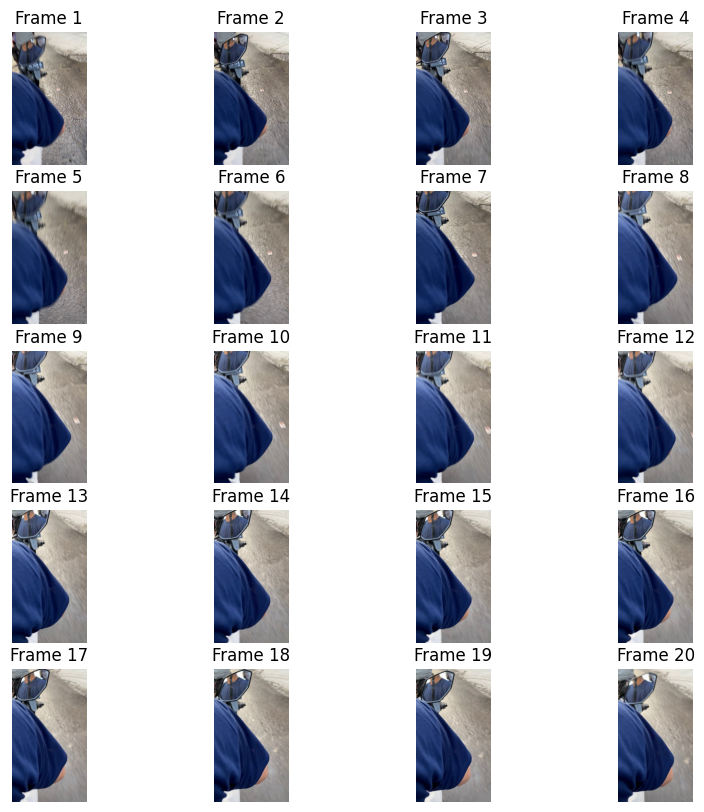

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path direktori yang berisi frame-frame hasil ekstraksi
image_sequence_path = '/content/Frame'

# Mendapatkan daftar file dalam direktori
image_files = sorted(os.listdir(image_sequence_path))

# Batasi jumlah frame yang ditampilkan
max_frames = 20

# Menampilkan gambar
plt.figure(figsize=(10, 10))

for i, image_file in enumerate(image_files):
    if i >= max_frames:
        break  # Berhenti setelah 20 frame

    image_path = os.path.join(image_sequence_path, image_file)

    # Buka gambar menggunakan PIL (Python Imaging Library)
    img = Image.open(image_path)

    # Menampilkan gambar
    plt.subplot(5, 4, i + 1)  # Ubah angka 5, 4 sesuai dengan jumlah baris dan kolom yang Anda inginkan
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Frame {i+1}')

plt.show()


In [ ]:
#Frame count
num_frames = len(image_files)

# Show frame count
print(f'Frame Total: {num_frames}')

Frame Total: 1799


**Preparing model FILM to generate interpolation**

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

import requests
import numpy as np

from typing import Generator, Iterable, List, Optional
import mediapy as media

In [ ]:
model = hub.load("https://tfhub.dev/google/film/1")

In [ ]:
_UINT8_MAX_F = float(np.iinfo(np.uint8).max)

def load_image(img_url: str):
  """Returns an image with shape [height, width, num_channels], with pixels in [0..1] range, and type np.float32."""

  if (img_url.startswith("https")):
    user_agent = {'User-agent': 'Colab Sample (https://tensorflow.org)'}
    response = requests.get(img_url, headers=user_agent)
    image_data = response.content
  else:
    image_data = tf.io.read_file(img_url)

  image = tf.io.decode_image(image_data, channels=3)
  image_numpy = tf.cast(image, dtype=tf.float32).numpy()
  return image_numpy / _UINT8_MAX_F

Inbetween Frame

In [ ]:
# using images from the FILM repository (https://github.com/google-research/frame-interpolation/)

image_1_url = "/content/Frame/frame_0099.jpg"#harus diganti
image_2_url = "/content/Frame/frame_0101.jpg"#harus diganti

time = np.array([0.5], dtype=np.float32)

image1 = load_image(image_1_url)
image2 = load_image(image_2_url)

In [ ]:
input = {
    'time': np.expand_dims(time, axis=0), # adding the batch dimension to the time
     'x0': np.expand_dims(image1, axis=0), # adding the batch dimension to the image
     'x1': np.expand_dims(image2, axis=0)  # adding the batch dimension to the image
}
mid_frame = model(input)

In [ ]:
print(mid_frame.keys())

dict_keys(['x0_warped', 'x1_warped', 'forward_flow_pyramid', 'image', 'forward_residual_flow_pyramid', 'backward_residual_flow_pyramid', 'backward_flow_pyramid'])


Generated Image 99 & 101

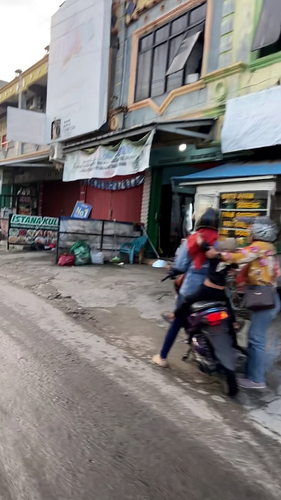

In [ ]:
import os
import numpy as np
import imageio
from mediapy import show_images

# Assuming 'mid_frame' is already defined and contains the generated frame
frames = [mid_frame['image'][0].numpy()]  # Replace with the desired frame

# Define the output directory
output_dir = '/content/drive/MyDrive/Prep_Thesis/realfootage/generatedframe'
# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save the generated image
generated_image = mid_frame['image'][0].numpy()

# Convert the data type to uint8 and scale to the range 0-255 if needed
generated_image = (generated_image * 255).astype(np.uint8)

output_image_path = os.path.join(output_dir, '1RealFootageVideo_generated_image_0099_0101.jpg') # Replace with the desired filename
imageio.imwrite(output_image_path, generated_image)

# Display the image from the list of frames
show_images(frames, titles=['Generated Image 99 & 101'], height=500) # Replace with the desired title


Frame 99,(Inbetween) Generated Image,Frame 101

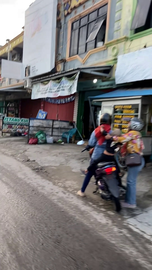
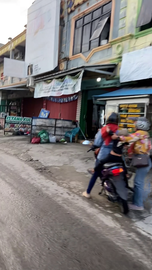
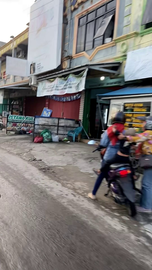

In [ ]:
import mediapy as media
frames = [image1, mid_frame['image'][0].numpy(), image2]

media.show_images(frames, titles=['Frame 99', '(Inbetween) Generated Image', 'Frame 101'], height=270)#harus diganti

In [ ]:
media.show_video(frames, fps=3, title='FILM interpolated video', height=500)

In [ ]:
"""A wrapper class for running a frame interpolation based on the FILM model on TFHub

Usage:
  interpolator = Interpolator()
  result_batch = interpolator(image_batch_0, image_batch_1, batch_dt)
  Where image_batch_1 and image_batch_2 are numpy tensors with TF standard
  (B,H,W,C) layout, batch_dt is the sub-frame time in range [0..1], (B,) layout.
"""


def _pad_to_align(x, align):
  """Pads image batch x so width and height divide by align.

  Args:
    x: Image batch to align.
    align: Number to align to.

  Returns:
    1) An image padded so width % align == 0 and height % align == 0.
    2) A bounding box that can be fed readily to tf.image.crop_to_bounding_box
      to undo the padding.
  """
  # Input checking.
  assert np.ndim(x) == 4
  assert align > 0, 'align must be a positive number.'

  height, width = x.shape[-3:-1]
  height_to_pad = (align - height % align) if height % align != 0 else 0
  width_to_pad = (align - width % align) if width % align != 0 else 0

  bbox_to_pad = {
      'offset_height': height_to_pad // 2,
      'offset_width': width_to_pad // 2,
      'target_height': height + height_to_pad,
      'target_width': width + width_to_pad
  }
  padded_x = tf.image.pad_to_bounding_box(x, **bbox_to_pad)
  bbox_to_crop = {
      'offset_height': height_to_pad // 2,
      'offset_width': width_to_pad // 2,
      'target_height': height,
      'target_width': width
  }
  return padded_x, bbox_to_crop


class Interpolator:
  """A class for generating interpolated frames between two input frames.

  Uses the Film model from TFHub
  """

  def __init__(self, align: int = 64) -> None:
    """Loads a saved model.

    Args:
      align: 'If >1, pad the input size so it divides with this before
        inference.'
    """
    self._model = hub.load("https://tfhub.dev/google/film/1")
    self._align = align

  def __call__(self, x0: np.ndarray, x1: np.ndarray,
               dt: np.ndarray) -> np.ndarray:
    """Generates an interpolated frame between given two batches of frames.

    All inputs should be np.float32 datatype.

    Args:
      x0: First image batch. Dimensions: (batch_size, height, width, channels)
      x1: Second image batch. Dimensions: (batch_size, height, width, channels)
      dt: Sub-frame time. Range [0,1]. Dimensions: (batch_size,)

    Returns:
      The result with dimensions (batch_size, height, width, channels).
    """
    if self._align is not None:
      x0, bbox_to_crop = _pad_to_align(x0, self._align)
      x1, _ = _pad_to_align(x1, self._align)

    inputs = {'x0': x0, 'x1': x1, 'time': dt[..., np.newaxis]}
    result = self._model(inputs, training=False)
    image = result['image']

    if self._align is not None:
      image = tf.image.crop_to_bounding_box(image, **bbox_to_crop)
    return image.numpy()

In [ ]:
def _recursive_generator(
    frame1: np.ndarray, frame2: np.ndarray, num_recursions: int,
    interpolator: Interpolator) -> Generator[np.ndarray, None, None]:
  """Splits halfway to repeatedly generate more frames.

  Args:
    frame1: Input image 1.
    frame2: Input image 2.
    num_recursions: How many times to interpolate the consecutive image pairs.
    interpolator: The frame interpolator instance.

  Yields:
    The interpolated frames, including the first frame (frame1), but excluding
    the final frame2.
  """
  if num_recursions == 0:
    yield frame1
  else:
    # Adds the batch dimension to all inputs before calling the interpolator,
    # and remove it afterwards.
    time = np.full(shape=(1,), fill_value=0.5, dtype=np.float32)
    mid_frame = interpolator(
        np.expand_dims(frame1, axis=0), np.expand_dims(frame2, axis=0), time)[0]
    yield from _recursive_generator(frame1, mid_frame, num_recursions - 1,
                                    interpolator)
    yield from _recursive_generator(mid_frame, frame2, num_recursions - 1,
                                    interpolator)


def interpolate_recursively(
    frames: List[np.ndarray], num_recursions: int,
    interpolator: Interpolator) -> Iterable[np.ndarray]:
  """Generates interpolated frames by repeatedly interpolating the midpoint.

  Args:
    frames: List of input frames. Expected shape (H, W, 3). The colors should be
      in the range[0, 1] and in gamma space.
    num_recursions: Number of times to do recursive midpoint
      interpolation.
    interpolator: The frame interpolation model to use.

  Yields:
    The interpolated frames (including the inputs).
  """
  n = len(frames)
  for i in range(1, n):
    yield from _recursive_generator(frames[i - 1], frames[i],
                                    times_to_interpolate, interpolator)
  # Separately yield the final frame.
  yield frames[-1]

In [ ]:
times_to_interpolate = 30
interpolator = Interpolator()

In [ ]:
print(f'video with {len(frames)} frames')
media.show_video(frames, fps=30, title='FILM interpolated video', height=500)

video with 3 frames


In [ ]:
#@inproceedings{reda2022film,
 #title = {FILM: Frame Interpolation for Large Motion},
 #author = {Fitsum Reda and Janne Kontkanen and Eric Tabellion and Deqing Sun and Caroline Pantofaru and Brian Curless},
 #booktitle = {The European Conference on Computer Vision (ECCV)},
 #year = {2022}
#}

In [ ]:
#@misc{film-tf,
  #title = {Tensorflow 2 Implementation of "FILM: Frame Interpolation for Large Motion"},
  #author = {Fitsum Reda and Janne Kontkanen and Eric Tabellion and Deqing Sun and Caroline Pantofaru and Brian Curless},
  #year = {2022},
  #publisher = {GitHub},
  #journal = {GitHub repository},
  #howpublished = {\url{https://github.com/google-research/frame-interpolation} }
#}

mengecek perbandingan visual Interpolate kasus dengan interpolate normal

<ipython-input-22-165aa146c748>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return imageio.imread(file_path)


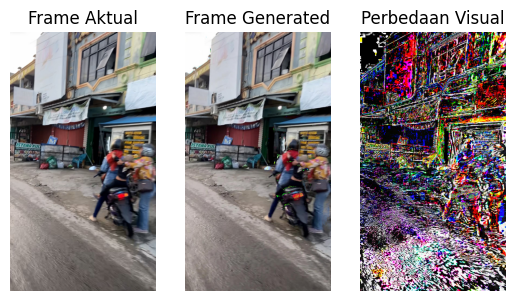

In [ ]:
import imageio
import matplotlib.pyplot as plt
import numpy as np

# Fungsi untuk memuat gambar
def load_image(file_path):
    return imageio.imread(file_path)

# Path file gambar Frame yang sengaja dihilangkan
image_path1 = '/content/drive/MyDrive/Prep_Thesis/realfootage/Frame/Missing Frame References/F100.jpg'#harus diganti
# Path file gambar Frame generated dari FILM
image_path2 = '/content/drive/MyDrive/Prep_Thesis/realfootage/generatedframe/1RealFootageVideo_generated_image_0099_0101.jpg'#harus diganti

# Memuat kedua gambar
image1 = load_image(image_path1)
image2 = load_image(image_path2)

# Menghitung perbedaan antara dua gambar
difference = np.abs(image1 - image2)

# Menampilkan gambar pertama
plt.subplot(1, 3, 1)
plt.imshow(image1)
plt.title('Frame Aktual')
plt.axis('off')

# Menampilkan gambar kedua
plt.subplot(1, 3, 2)
plt.imshow(image2)
plt.title('Frame Generated')
plt.axis('off')

# Menampilkan perbedaan visual
plt.subplot(1, 3, 3)
plt.imshow(difference, cmap='gray')
plt.title('Perbedaan Visual')
plt.axis('off')

plt.show()

<ipython-input-23-1c791874d641>:4: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value, ssim_image = ssim(image1, image2, full=True, multichannel=True)


SSIM antara Frame Aktual dan Frame Generated: 0.8348181198049036


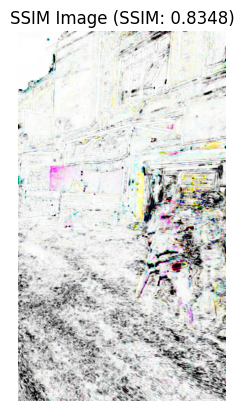

In [ ]:
from skimage.metrics import structural_similarity as ssim

# Menghitung SSIM antara dua gambar
ssim_value, ssim_image = ssim(image1, image2, full=True, multichannel=True)

# Menampilkan hasil SSIM
print(f'SSIM antara Frame Aktual dan Frame Generated: {ssim_value}')

# Menampilkan gambar SSIM
plt.imshow(ssim_image, cmap='gray')
plt.title(f'SSIM Image (SSIM: {ssim_value:.4f})')
plt.axis('off')
plt.show()


In [ ]:
from skimage import io
from skimage.metrics import structural_similarity as ssim

# Path file gambar Frame yang sengaja dihilangkan
image_path1 = '/content/drive/MyDrive/Prep_Thesis/realfootage/Frame/Missing Frame References/F100.jpg'#harus diganti
# Path file gambar Frame generated dari FILM
image_path2 = '/content/drive/MyDrive/Prep_Thesis/realfootage/generatedframe/1RealFootageVideo_generated_image_0099_0101.jpg'#harus diganti

# Memuat kedua gambar
image1 = load_image(image_path1)
image2 = load_image(image_path2)

# Memuat kedua gambar
image1 = io.imread(image_path1)
image2 = io.imread(image_path2)

# Pastikan gambar minimal berukuran 7x7, atau setel win_size lebih kecil
win_size = min(image1.shape[0], image1.shape[1], image2.shape[0], image2.shape[1], 7)

# Hitung SSIM antara dua gambar dengan win_size yang ditentukan dan channel_axis
ssim_index, _ = ssim(image1, image2, full=True, win_size=win_size, channel_axis=-1)

# Klasifikasi nilai SSIM
if ssim_index >= 0.8:
    quality = "Tinggi"
elif ssim_index >= 0.5:
    quality = "Sedang"
else:
    quality = "Rendah"

print(f'SSIM: {ssim_index:.4f} ({quality})')


<ipython-input-22-165aa146c748>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return imageio.imread(file_path)


SSIM: 0.8348 (Tinggi)
